## Modified Slim

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import deepxde as dde

######################
# ITER shape #
######################
eps_deviation = 0.2
kappa_deviation = 0.5
delta_deviation = 0.2
eps0 = (0.32 - eps_deviation, 0.32 + eps_deviation)
kappa0 = (1.7 - kappa_deviation, 1.7 + kappa_deviation)
delta0 = (0.33 - delta_deviation, 0.33 + delta_deviation)
Amax = 0.1
num_param = 2
Arange = np.linspace(-Amax, Amax, num_param)
eps = np.linspace(eps0[0], eps0[1], num_param)
kappa = np.linspace(kappa0[0], kappa0[1], num_param)
delta = np.linspace(delta0[0], delta0[1], num_param)

def gen_traindata(num):
    ######################
    # ITER Configuration #
    ######################

    N = num
    center = np.array(
        [[0.0, 0.0, 0.0, 
          eps0[1] - eps0[0], 
          kappa0[1] - kappa0[0],
          delta0[1] - delta0[0]]]
    )
    tau = np.linspace(0, 2 * np.pi, N)
    R_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    Z_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    A_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    eps_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    kappa_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    delta_ellipse = np.zeros((N, num_param, num_param, num_param, num_param))
    for i in range(num_param):
        for j in range(num_param):
            for k in range(num_param):
                for kk in range(num_param):
                    R_ellipse[:, i, j, k, kk] = 1 + eps[j] * np.cos(tau + np.arcsin(delta[kk]) * np.sin(tau))
                    Z_ellipse[:, i, j, k, kk] = eps[j] * kappa[k] * np.sin(tau)
                    A_ellipse[:, i, j, k, kk] = Arange[i]
                    eps_ellipse[:, i, j, k, kk] = eps[j]
                    kappa_ellipse[:, i, j, k, kk] = kappa[k]
                    delta_ellipse[:, i, j, k, kk] = delta[kk]
    
    x_ellipse = np.transpose(
        np.asarray([
            R_ellipse, Z_ellipse, A_ellipse, 
            eps_ellipse, kappa_ellipse, delta_ellipse]), 
                             [1, 2, 3, 4, 5, 0])
    x_ellipse = x_ellipse.reshape(N * num_param ** 4, 6)

    print(x_ellipse.shape)
    uvals = np.zeros(len(x_ellipse)).reshape(len(x_ellipse), 1)
    return x_ellipse, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    A = x[:, 2:3]
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)


spatial_domain = dde.geometry.HyperEllipticalToroid(eps0, kappa0, delta0, Amax=Amax) 

x, u = gen_traindata(100)

n_test = 100
x_test,u_test = gen_traindata(n_test)
x_domain = spatial_domain.random_points(n_test)
x_test = np.concatenate((x_test, x_domain))
u_test = np.concatenate((u_test, np.zeros((n_test, 1))))

bc135 = dde.PointSetBC(x,u)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    [bc135],
    num_domain=2048,
    num_boundary=0,
    x_test=x_test,
    y_test=u_test,
    train_distribution="LHS"
)


Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term
(1600, 6)
(1600, 6)


In [3]:
data.train_x_bc.shape

(1600, 6)

In [4]:
# Plot collocation points for visual check
%matplotlib

fig,ax=plt.subplots(1, figsize=(5,5))
ax.scatter(data.train_x_bc[:,0], data.train_x_bc[:,1], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

fig =plt.figure(2, figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter(data.train_x[:,0], data.train_x[:,1], data.train_x[:,2], s = 2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')

Using matplotlib backend: MacOSX


Text(0.5, 0, '$u(r,z=0)$')

In [4]:
from utils.gs_solovev_sol import GS_Linear
# tokamak = GS_Linear(A=-0.155, eps= 2/6.2, kappa=1.6, delta=0.4)

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.079829 s



/Users/alankaptanoglu/deepxde_copy/deepxde/maps/fnn.py:112: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 1.910193 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [8.97e-01, 3.44e-04]    [1.13e+00, 0.00e+00]    []  
10        [1.58e-01, 7.46e-03]    [3.82e-01, 0.00e+00]    []  
20        [3.07e-02, 1.83e-02]    [7.64e-02, 0.00e+00]    []  
30        [1.08e-02, 8.04e-03]    [1.88e-02, 0.00e+00]    []  
40        [5.10e-03, 4.46e-03]    [1.73e-02, 0.00e+00]    []  
50        [2.57e-03, 1.22e-03]    [4.55e-03, 0.00e+00]    []  
60        [9.06e-04, 7.77e-04]    [5.55e-03, 0.00e+00]    []  
70        [5.86e-04, 4.56e-04]    [1.97e-03, 0.00e+00]    []  
80        [3.96e-04, 3.47e-04]    [3.08e-03, 0.00e+00]    []  
90        [9.54e-04, 3.44e-04]    [2.23e-03, 0.00e+00]    []  
100       [3.76e-03, 2.54e-04]    [8.46e-03, 0.00e+00]    []  

Best model at step 80:
  train loss: 7.43e-04
  test loss: 3.08e-03
  test metric: []

'train' took 133.226212 s

Saving loss history to ./cefron/ITER/runs/network_

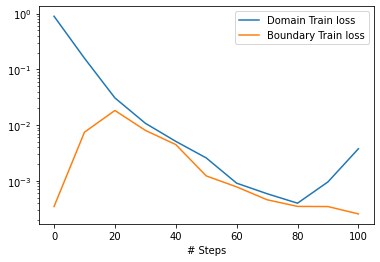

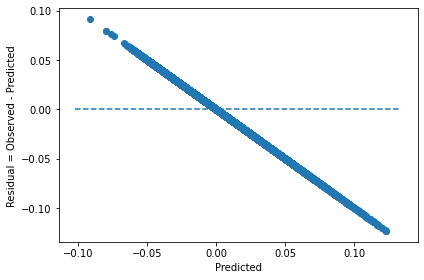

In [5]:
#[0.02,0.007,0.002,0.0007,0.0002]
import os
DATE = "10122022"
CONFIG = "ITER"
LR = 2e-2
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN([6] + DEPTH * [BREADTH] + [1], AF, "Glorot normal")

model = dde.Model(data, net)
decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1]
  )
  loss_history, train_state = model.train(epochs=100, display_every = 10)
  dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')

#### After BFGS

In [6]:
# Compile, train and save model
options={
    "maxiter": LBFGS_options["maxiter"],
    "maxls": LBFGS_options["maxls"],
},
model.compile(
    "L-BFGS-B", 
    loss_weights=[1,100],
    options
)
loss_history, train_state = model.train(epochs=1000, display_every = 10)
dde.saveplot(loss_history, train_state, save_plot=True,issave=True, isplot=True,output_dir=f'./cefron/{CONFIG}/runs/{RUN_NAME}')


SyntaxError: positional argument follows keyword argument (<ipython-input-6-896e6ef2ad9f>, line 9)

In [7]:
# Evaluation
from utils.utils import evaluate_A, relative_error_plot
#ITER = GS_parametrized(eps0, kappa0, delta0, Amax)
ITER = GS_Linear(eps=eps[0], kappa=kappa[0], delta=delta[0])
full, yfull, A, psi_pred_full, psi_true_full, error = evaluate_A(
    ITER, model, Amax, num_param
)
nx = psi_true_full.shape[0]
ny = psi_true_full.shape[0]
psi_pred_parametrized = np.zeros(
    (nx, ny, num_param, num_param, num_param, num_param)
)
psi_true_parametrized = np.zeros(
    (nx, ny, num_param, num_param, num_param, num_param)
)
for i in range(num_param):
    for j in range(num_param):
        for k in range(num_param):
            ITER = GS_Linear(eps=eps[i], kappa=kappa[j], delta=delta[k])
            xfull, yfull, A, psi_pred_full, psi_true_full, error = evaluate_A(
                ITER, model, Amax, num_param
            )
            psi_pred_parametrized[:, :, :, i, j, k] = psi_pred_full
            psi_true_parametrized[:, :, :, i, j, k] = psi_true_full


(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1000, 6)
(13005, 6)
(1

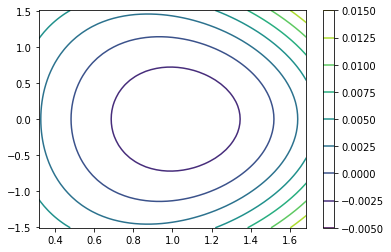

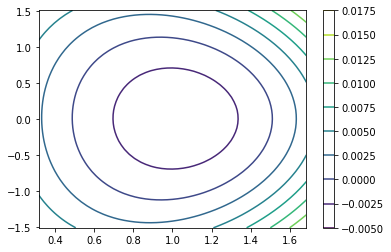

In [8]:
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_true_parametrized[:, :, 0, 0, 0, 0])
plt.colorbar()
plt.figure()
plt.contour(xfull[:, :, 0], yfull[:, :, 0], psi_pred_parametrized[:, :, 0, 0, 0, 0])
plt.colorbar()

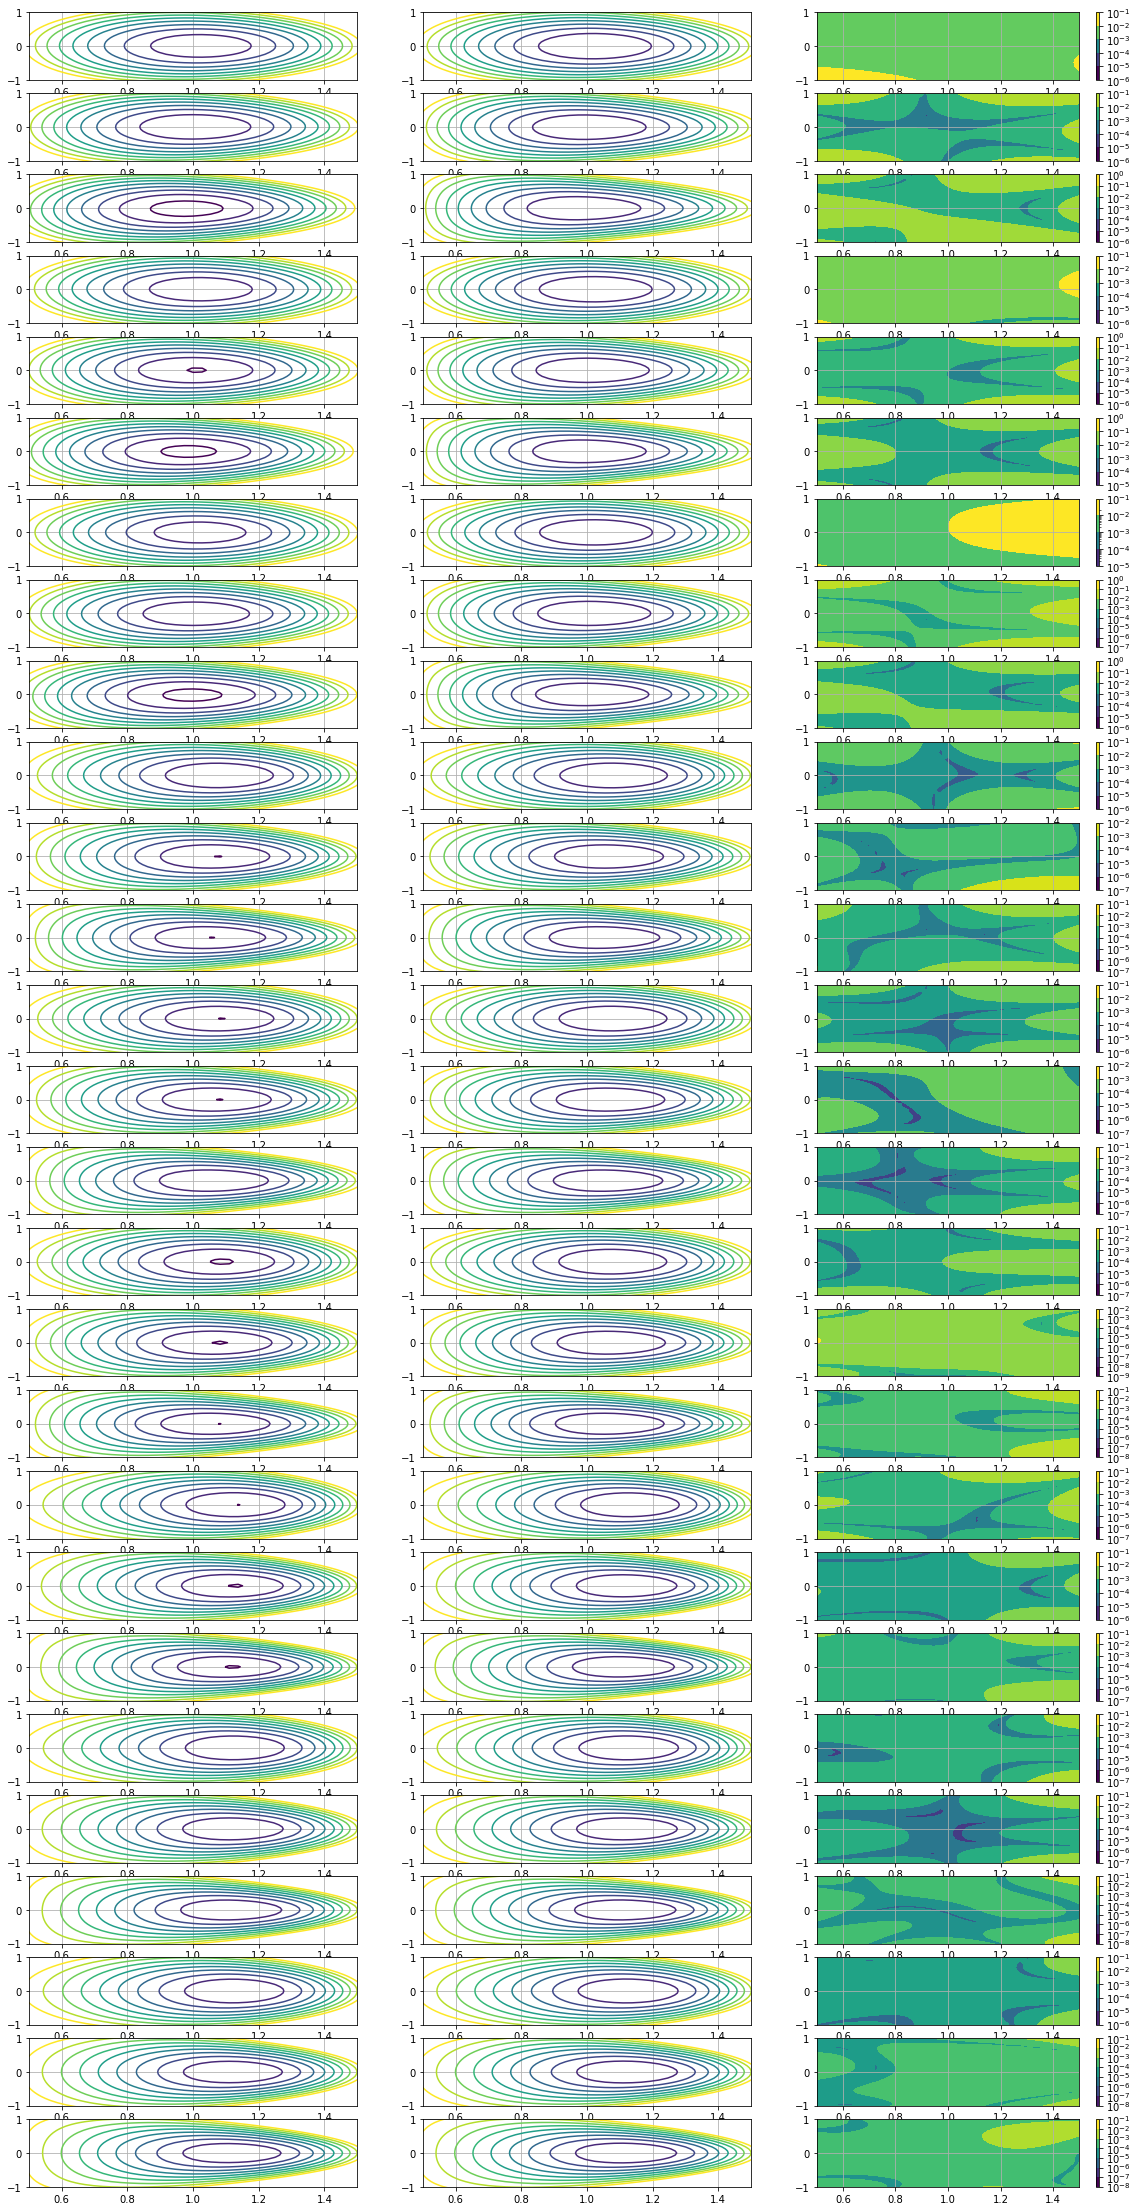

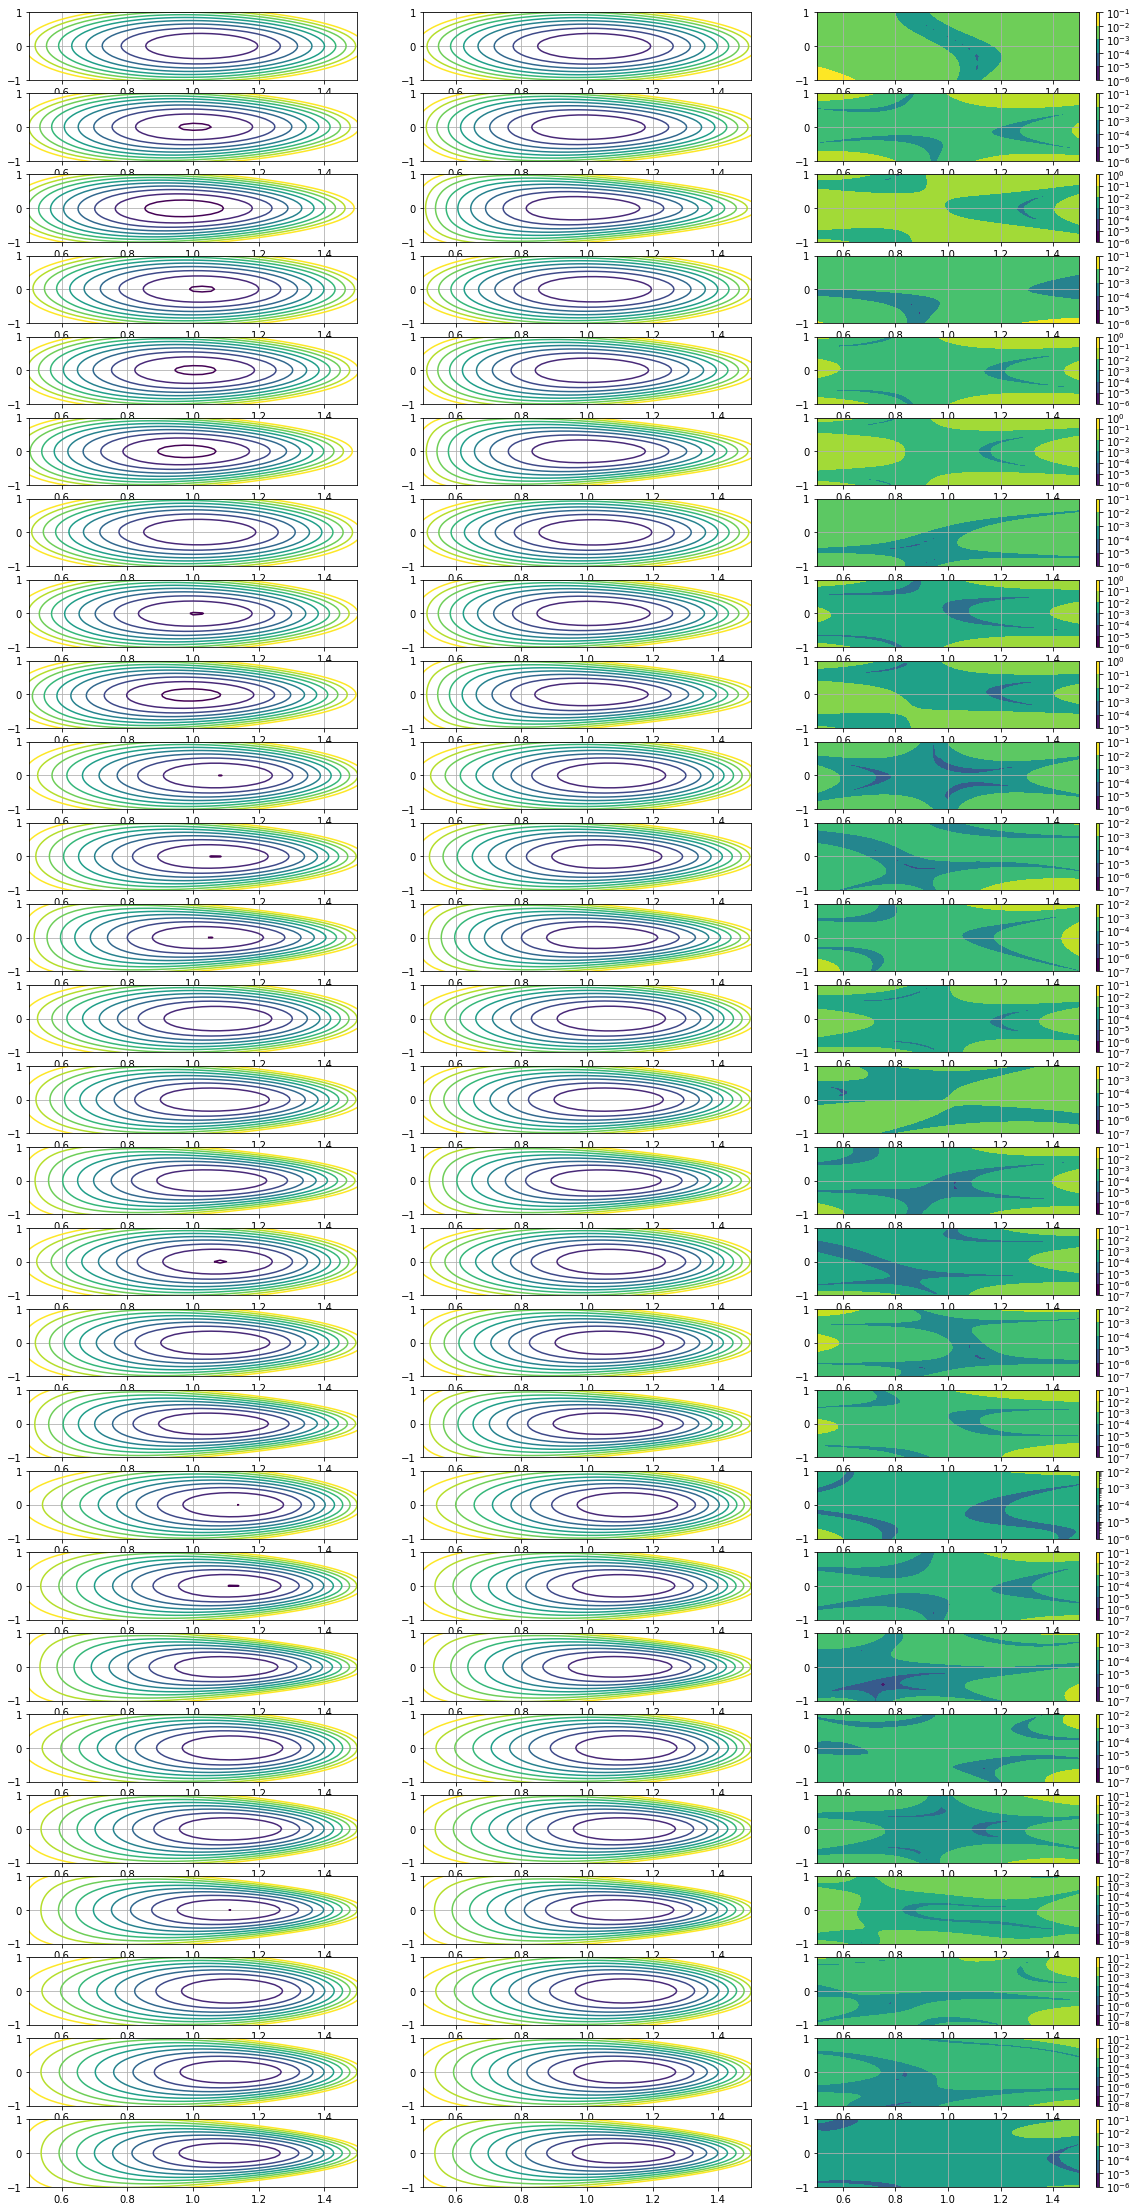

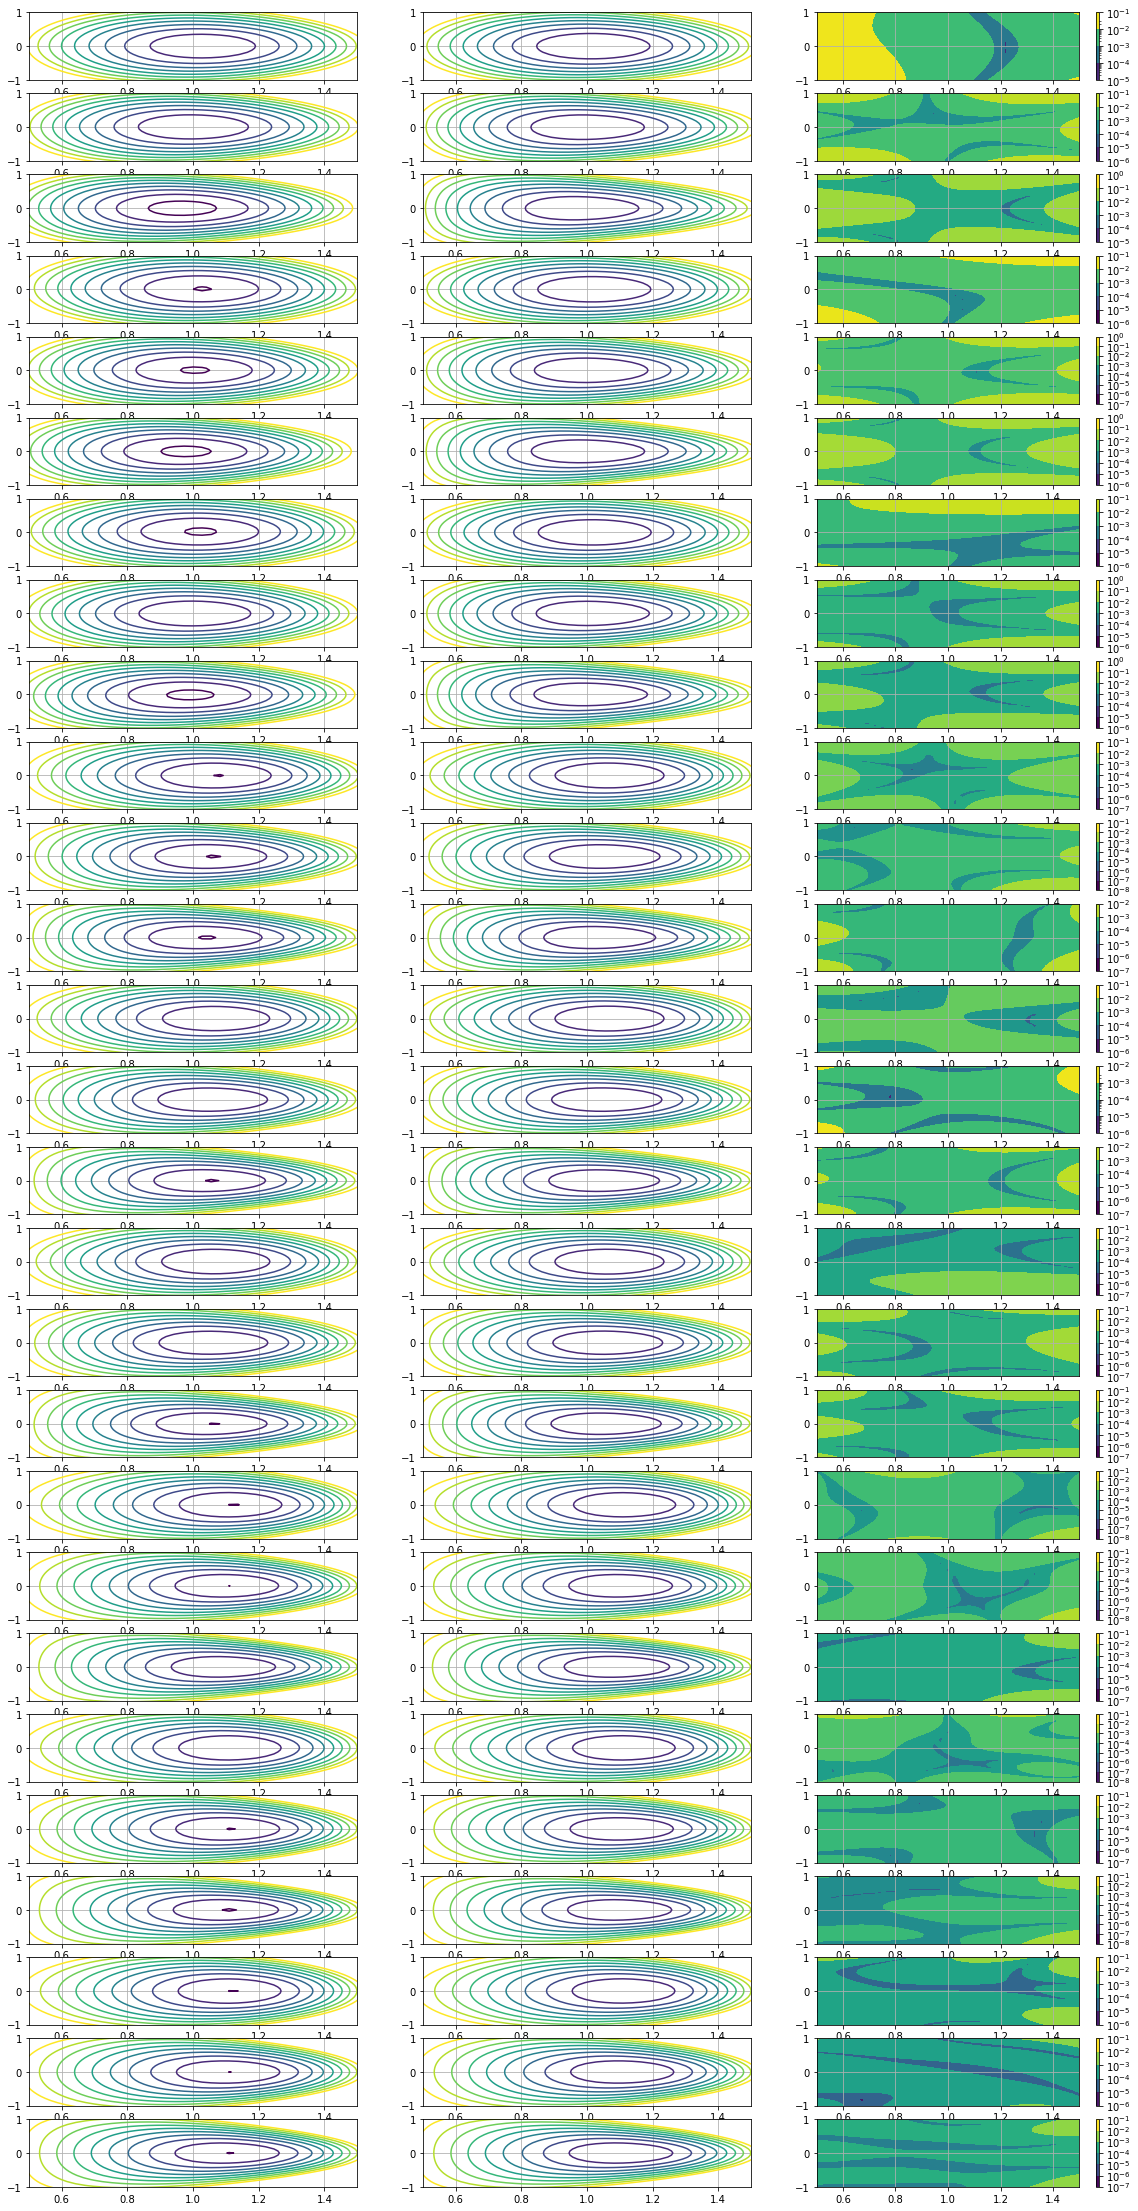

In [19]:
# Plotting Setup
import matplotlib.colors as colors

for i in range(0, num_param, 2):
    plt.figure(i + 1, figsize=(20, 40))
    q = 1
    for j in range(0, num_param, 2):
        for k in range(0, num_param, 2):
            for kk in range(0, num_param, 2):
#                 zoom = ((1 + eps[j])-(1 - eps[j]))*0.05
#                 innerPoint = 1 - eps[j] - zoom
#                 outerPoint = 1 + eps[j] + zoom
#                 lowPoint   = -kappa[k] * eps[j] - zoom
#                 highPoint  = kappa[k] * eps[j] + zoom
                innerPoint = 0.5
                outerPoint = 1.5
                lowPoint = -1
                highPoint = 1
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q)
                levels = np.linspace(
                    min(psi_true_parametrized[:, :, i, j, k, kk].reshape(-1)), 0, 10
                )    
                cp = plt.contour(
                    xfull[:, :, i], yfull[:, :, i], 
                    psi_pred_parametrized[:, :, i, j, k, kk],
                    levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q + 1)
                cp = plt.contour(
                    xfull[:, :, i], 
                    yfull[:, :, i], 
                    psi_true_parametrized[:, :, i, j, k, kk],
                    levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.subplot(int(np.ceil(num_param / 2)) ** 3, 3, q + 2)
                errors = abs(psi_true_parametrized[:, :, i, j, k, kk] - psi_pred_parametrized[:, :, i, j, k, kk]) / np.max(
                        abs(psi_true_parametrized[:, :, i, j, k, kk]))
                cp = plt.contourf(
                    xfull[:, :, i], 
                    yfull[:, :, i], 
                    errors,
                    norm=colors.LogNorm(vmin=errors.min(), 
                                        vmax=errors.max()),
                    #levels=levels
                )
                plt.grid(True)
                plt.axis(
                    xmin=innerPoint,
                    xmax=outerPoint,
                    ymin=lowPoint, 
                    ymax=highPoint
                )
                plt.colorbar()
                q = q + 3

In [10]:
import time 

nx = 30
ny = nx
zoom = 0.2
inner_point = (1 - 1.1*ITER.eps*(1+zoom))
outer_point = (1 + 1.1*ITER.eps*(1+zoom))
high_point  = (1.1*ITER.kappa * ITER.eps*(1+zoom) )
low_point   = (-1.1*ITER.kappa * ITER.eps*(1+zoom) )
x, y, A = np.meshgrid(
    np.linspace(inner_point, outer_point, nx),
    np.linspace(low_point, high_point, ny),
    np.linspace(-Amax, Amax, num_param),
    indexing='ij'
)
ones = np.ones(nx * ny * num_param)

X = np.vstack((
    np.ravel(x), np.ravel(y), np.ravel(A),
    ITER.eps * ones, ITER.kappa * ones, ITER.delta * ones
)).T
print(X.shape)
t1 = time.time()
model.predict(X)
t2 = time.time()
print(t2 - t1)

(4500, 6)
0.00420689582824707
